 ## 📌 ACTIVIDAD 2: UN CASO DE REGRESIÓN MÁS REAL.


Crea el notebook saa_u03_p01_a2-<tus_iniciales>.ipynb donde entregar esta actividad. En el fichero
centro-comercial.csv tenemos registrada la facturación semanal conseguida en unos 45 centros
comerciales de una cadena de supermercados registrada un día concreto de cada semana. Tenemos
datos de varios años y queremos tener un modelo de Machine Learning que nos permita predecir las
ventas semanales a partir de otros datos que se indiquen.

 Nota: este ejercicio tiene un obstáculo que debes detectar para poder resolverlo de manera correcta (a mi
se me ocurren dos posibles soluciones aplicadas en la fase de preprocesamiento y en el ajuste de
parámetros, aunque solamente he probado una y es posible que haya más).

### COMPARATIVA DE VARIOS REGRESORES

Carga en un DataFrame el archivo centro-comercial.csv y realiza este preprocesamiento básico:
análisis exploratorio de datos y selección de características.

In [26]:
from sklearn.pipeline import Pipeline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar datos
df = pd.read_csv('../U03_Recursos/U03_P01_Regresiones/centro-comercial.csv')
df.head()

,centro,fecha,ventas_semanales,festivo,temperatura,precio_gasolina,IPC,desempleo
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


PRIMERA ETAPA: EDA.

 • Muestra unas filas del dataset y cuantas características y ejemplos tiene

In [27]:
# Ver dimensiones
print(f"Número de ejemplos: {df.shape[0]}")
print(f"Número de características: {df.shape[1]}")

Número de ejemplos: 6435
Número de características: 8


 • Cambiar la característica fecha por 3 características nuevas: día de la semana, mes y año.
Puedes convertir las fechas en tipo Date con la función de pandas to_datetime(fecha,
formato) donde tendrás que indicar el formato porque utiliza por defecto el inglés. El formato
es un texto con comodines donde %d es el día, %m es el mes y %Y es el año con 4 dígitos. Cuando
la tengas convertida a tipo Date puedes extraerle información con expresiones como
pd.fecha.dt.year que te devuelve el año.

In [28]:
# Convertir fecha a datetime con el día primero
df['fecha'] = pd.to_datetime(df['fecha'], dayfirst=True)

# Extraer día, mes y año
df['dia_semana'] = df['fecha'].dt.dayofweek
df['mes'] = df['fecha'].dt.month
df['año'] = df['fecha'].dt.year

# Eliminar la columna original de fecha
df.drop(columns=['fecha'], inplace=True)

• Ahora cuenta y muestra la cantidad de diferentes valores que tiene
cada característica con df.nunique() para detectar posibles problemas
(que haya 13 meses por ejemplo) o detectar las que quizás sean
booleanas (tendrán 2 valores) y en definitiva comprender mejor los
datos.

In [29]:
# Ver valores únicos por columna
display(df.nunique())

centro                45
ventas_semanales    6435
festivo                2
temperatura         3528
precio_gasolina      892
IPC                 2145
desempleo            349
dia_semana             1
mes                   12
año                    3
dtype: int64

 • Definimos una variable target que será "ventas_semanales" y otra de
tipo lista llamada predictoras que contenga el resto de características
menos el target.

In [30]:
# Definir target y predictoras
target = 'ventas_semanales'
predictoras = [col for col in df.columns if col != target]

# Clasificar numéricas y categóricas
nu = df[predictoras].nunique().sort_values()
nf = []; cf = []

for col in nu.index:
    if nu[col] < 0.005 * len(df):
        cf.append(col)
    else:
        nf.append(col)

print("Numéricas:", nf)
print("Categóricas:", cf)

Numéricas: ['centro', 'desempleo', 'precio_gasolina', 'IPC', 'temperatura']
Categóricas: ['dia_semana', 'festivo', 'año', 'mes']


 • Intentamos detectar qué características pueden ser pueden ser categóricas y cuales pueden ser
numéricas usando el criterio de la cantidad de valores diferentes que tengan. Si una
característica tiene menos del 0.5% de sus valores distintos es sospechosa de ser categórica
aunque sus valores sean numéricos. Completa el código que crea la lista nf con los nombres de
las características numéricas y la lista cf con las categóricas y las imprima:


In [31]:
nu = df[predictoras].nunique().sort_values()
nf = []; cf = [];

 • Dibujar un histograma del target con seaborn por ejemplo usando histplot().


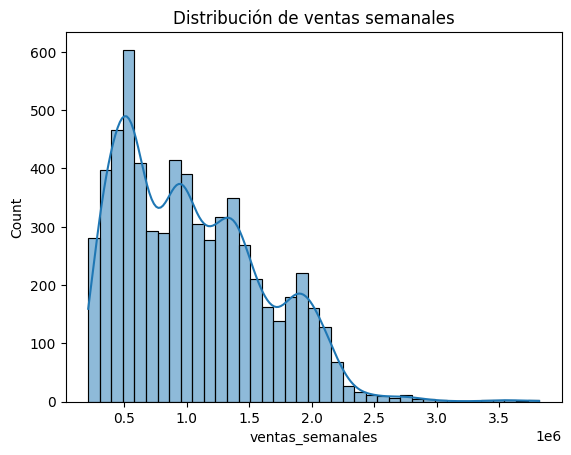

In [32]:
# Histograma del target
sns.histplot(df[target], kde=True)
plt.title('Distribución de ventas semanales')
plt.show()


 • Completa este código que dibuja las distribuciones de las características numéricas para que
aparezca debajo del histograma de cada característica su boxplot y nos permitan visualizar la
presencia de outliers, tal y como se ve en la figura.

In [33]:
# Boxplots y distribuciones
for col in nf:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(df[col], ax=axes[0], kde=True)
    sns.boxplot(x=df[col], ax=axes[1])
    fig.suptitle(f'Distribución y boxplot de {col}')
    plt.tight_layout()
    plt.show()

SEGUNDA ETAPA: SELECCIÓN DE CARACTERÍSTICAS.


 • Elimina características del dataframe que no son útiles, y también debes borrarlas de las listas
de predictoras y de cualquier otra lista donde aparezcan.

 • Realiza operaciones de limpieza que consideres necesarias. Crea un objeto llamado
preprocesador de tipo ColumnTransformer que pueda utilizarse para aplicar transformaciones
cuando se necesiten:

 ◦ Tratamiento de valores ausentes.

 ◦ Eliminación de filas repetidas.

 ◦ Tratamiento de outliers.

 ◦ Codificación de variables categóricas.

 ◦ Escalado o estandarización.

 • Estudia la colinealidad entre las predictoras y el target y entre cada pareja de predictoras
numéricas calculando la matriz de correlaciones de las características numéricas y visualizando
un mapa de calor de color azul y blanco. Elimina predictoras que presenten una correlación
superior al 60%.


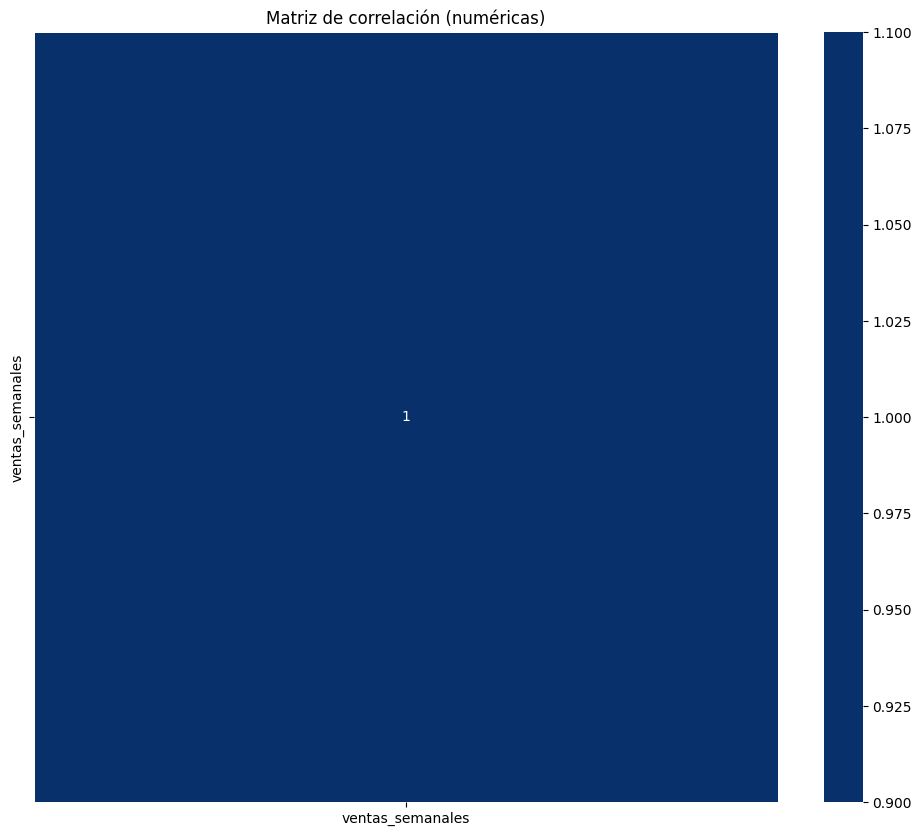

In [39]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. LIMPIEZA DE DATOS
# Eliminar duplicados
df.drop_duplicates(inplace=True)

# Eliminar columnas inútiles (ejemplo: IDs, nombres, etc.)
columnas_a_eliminar = ['id', 'nombre']  # ajusta esta lista a tu caso
df.drop(columns=columnas_a_eliminar, inplace=True, errors='ignore')

# Actualizar listas predictoras
nf = [col for col in nf if col not in columnas_a_eliminar]
cf = [col for col in cf if col not in columnas_a_eliminar]

# 2. TRATAMIENTO DE OUTLIERS
# Reemplazar outliers por NaN en variables numéricas
for col in nf:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    df[col] = np.where((df[col] < lower) | (df[col] > upper), np.nan, df[col])

# 3. PREPROCESADOR (ColumnTransformer)
preprocesador = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputador', SimpleImputer(strategy='mean')),
        ('escalado', StandardScaler())
    ]), nf),
    ('cat', Pipeline([
        ('imputador', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), cf)
])

# 4. MATRIZ DE CORRELACIÓN (solo con numéricas)
corr = df[nf + [target]].corr()

# Visualizar mapa de calor
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='Blues', center=0, linewidths=.5)
plt.title('Matriz de correlación (numéricas)')
plt.show()

# 5. ELIMINAR VARIABLES CON CORRELACIÓN > 0.6 ENTRE ELLAS
# Correlación absoluta
corr_matrix = corr.abs()

# Selección de columnas con alta correlación
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
cols_to_drop = [column for column in upper.columns if any(upper[column] > 0.6) and column != target]

# Eliminar del DataFrame y de las listas
df.drop(columns=cols_to_drop, inplace=True)
nf = [col for col in nf if col not in cols_to_drop]
cf = [col for col in cf if col not in cols_to_drop]


TERCERA ETAPA: PARTICIONAR DATOS


 • Inicializa a partir de ahora todos los procesos aleatorios con una semilla aleatoria obtenida
como
<letras_de_tu_nombre>
concatenar
<letras_apellido1>
concatenar
<letras_apellido2>, por ejemplo en mi caso sería 449 (Jose = 4, Rosa=4, Rodríguez=9).


• Deja para entrenamiento el 80% de los datos y divide en train y test.

In [36]:
from sklearn.model_selection import train_test_split

semilla = 675

X = df[predictoras]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=semilla)


CUARTA ETAPA: ENTRENAMIENTO Y SELECCIÓN DE MODELOS

• Vamos a realizar esta etapa de forma manual. Definimos en un diccionario llamado regresores
todos los regresores que vamos a entrenar metidos en un Pipeline donde primero aplicamos el
preproceso a los datos y luego entrenamos/predecimos con el modelo.

In [44]:
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR, NuSVR, LinearSVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor


preprocesador = StandardScaler()

# Definir los diferentes regresores
regresores = {
    'svr (linear)': Pipeline([('pre', preprocesador), ('regresor', SVR(kernel='linear', C=1.0, epsilon=0.1))]),
    'svr (poly)': Pipeline([('pre', preprocesador), ('regresor', SVR(kernel='poly', C=1.0, epsilon=0.1))]),
    'svr (rbf)': Pipeline([('pre', preprocesador), ('regresor', SVR(kernel='rbf', C=1.0, epsilon=0.1))]),
    'nusvr': Pipeline([('pre', preprocesador), ('regresor', NuSVR(nu=0.5, kernel='rbf', C=1.0))]),
    'linearSVR': Pipeline([('pre', preprocesador), ('regresor', LinearSVR(epsilon=0.1, random_state=449))]),
    'linear Regression': Pipeline([('pre', preprocesador), ('regresor', LinearRegression())]),
    'Ridge': Pipeline([('pre', preprocesador), ('regresor', Ridge(alpha=1.0))]),
    'Lasso': Pipeline([('pre', preprocesador), ('regresor', Lasso(alpha=0.1))]),
    'Random Forest': Pipeline([('pre', preprocesador), ('regresor', RandomForestRegressor(n_estimators=100, random_state=449))]),
    'Gradient Boosting': Pipeline([('pre', preprocesador), ('regresor', GradientBoostingRegressor(n_estimators=100, random_state=449))]),
    'K-Neighbors': Pipeline([('pre', preprocesador), ('regresor', KNeighborsRegressor(n_neighbors=5))]),
    'Decision Tree': Pipeline([('pre', preprocesador), ('regresor', DecisionTreeRegressor(random_state=449))])
}

from sklearn.preprocessing import StandardScaler

s_y = StandardScaler()
y_train_escalado = s_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_escalado = s_y.transform(y_test.values.reshape(-1, 1)).ravel()


 • Ahora definimos listas (mse_train, mse_test, r2_train, r2_test) para registrar el error que
comete cada modelo con train y con test para poder comprobar el desempeño de cada uno y
detectar situaciones no deseables. Completa o adapta el código para generar salida como esta:


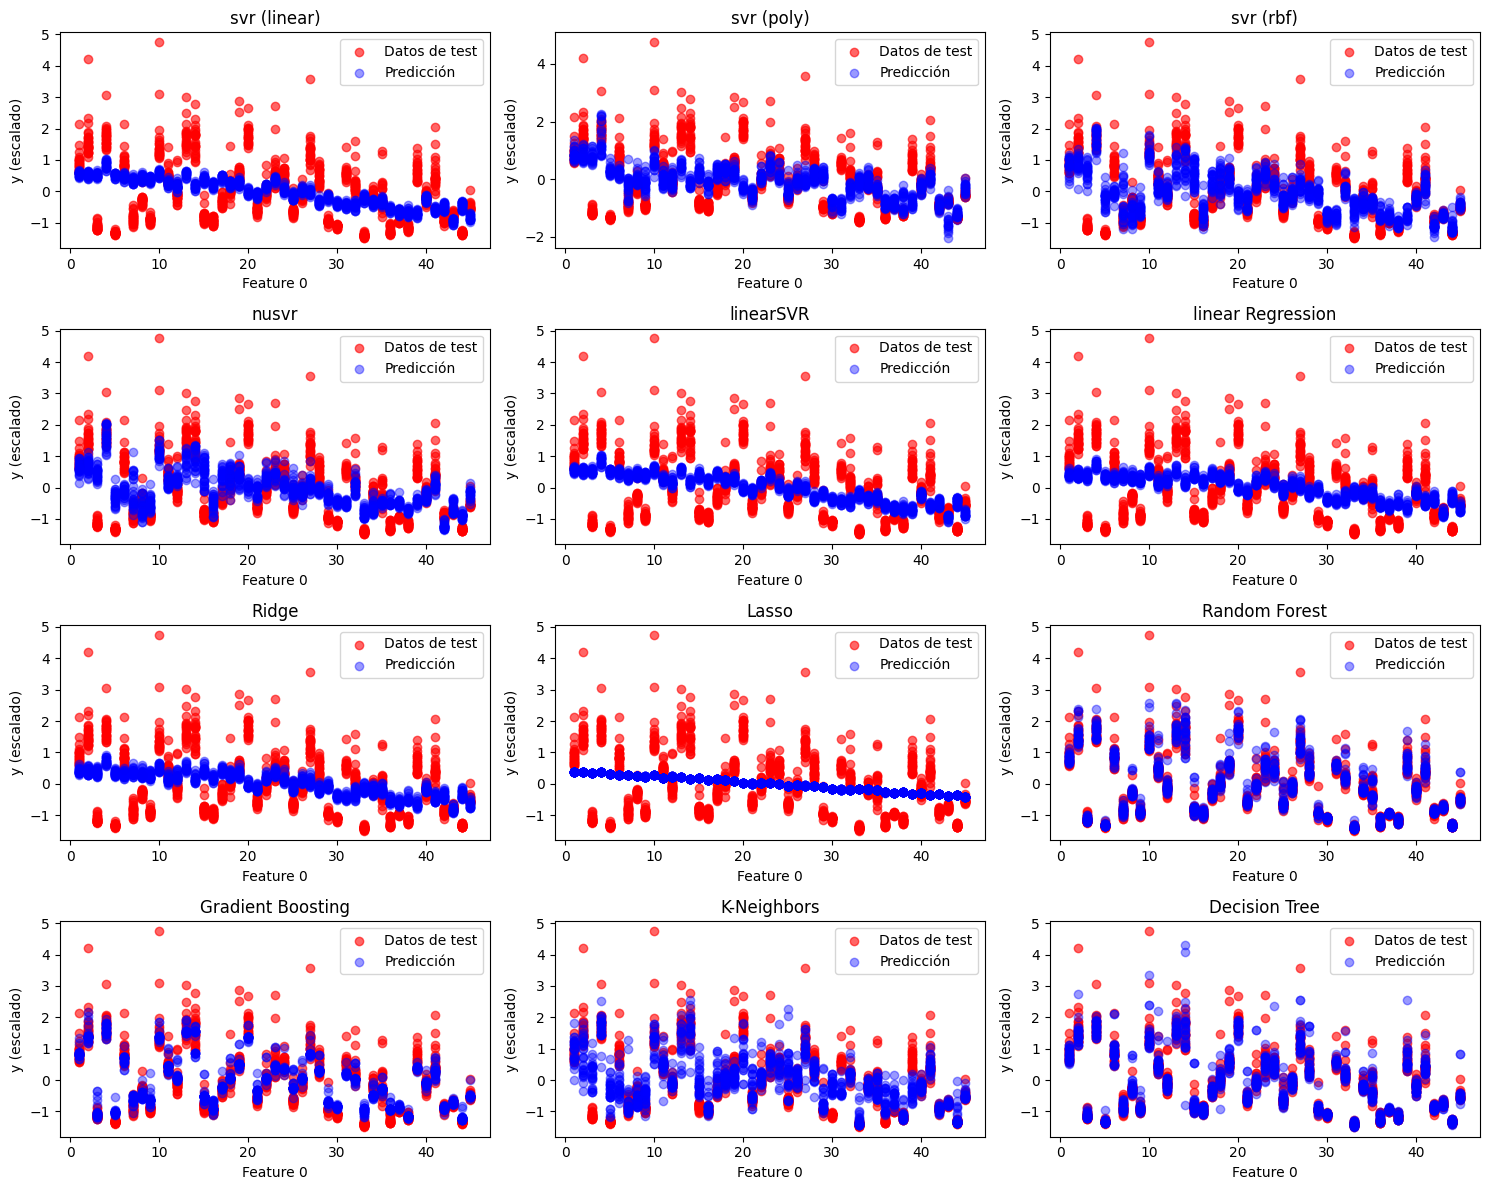

In [46]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

mse_train = []
mse_test = []
r2_train = []
r2_test = []

plt.figure(figsize=(15, 12))

for i, (nombre, modelo) in enumerate(regresores.items()):
    modelo.fit(X_train, y_train_escalado)

    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)

    # Guardar métricas
    mse_train.append(mean_squared_error(y_train_escalado, y_pred_train))
    mse_test.append(mean_squared_error(y_test_escalado, y_pred_test))
    r2_train.append(r2_score(y_train_escalado, y_pred_train))
    r2_test.append(r2_score(y_test_escalado, y_pred_test))

    # Graficar usando solo la primera columna de X_test
    plt.subplot(4, 3, i + 1)
    plt.scatter(X_test.iloc[:, 0], y_test_escalado, color='red', label='Datos de test', alpha=0.6)
    plt.scatter(X_test.iloc[:, 0], y_pred_test, color='blue', alpha=0.4, label='Predicción')
    plt.xlabel('Feature 0')
    plt.ylabel('y (escalado)')
    plt.title(nombre)
    plt.legend()

plt.tight_layout()
plt.show()


 • Además de imprimir los scores (MSE y R2) para cada modelo y registrarlos en las listas, vas a
generar un gráfico donde se vea:

 ◦ Un scatter de color rojo que representa cada valor de y_test. Esto genera una línea recta de
color rojo formada por los valores de test: los puntos (y_test, y_test) siempre ocuparán
la diagonal del gráfico.

 ◦ Otro scatter de color azul representa cada valor de y_test y cada valor predicho para ese
y_test. Así podremos hacernos una idea de cómo de próximas están las predicciones del
regresor a sus valores reales.

 ◦ Puedes seleccionar uno de los gráficos del plt.figure(figsize=(12,10)) de la línea 7
ejecutando antes de crear los gráficos, la sentencia plt.subplot(5,3,i+1) dentro del bucle.

 • Fuera del bucle vamos a comparar el MSE de los modelos con un gráfico de barras donde se vea
train y test. Esto nos ayudará a detectar posibles underfitting y overfitting y ver desempeño de
los modelos.


 ENTREGA 4: Muestra:

 a) Etapas y pasos de la actividad con el texto, el código y los gráficos y resultados que se
generan en un notebook de Jupyter.

 b) Responde mirando tu gráfico de MSE:

 • El peor modelo parece ser: Lasso

• El mejor modelo parece ser: Random Forest

• Cuál es el que tiene más overfitting: LinearRegression

•De manera similar haz un gráfico de barras donde aparezca el R2 de cada modelo.


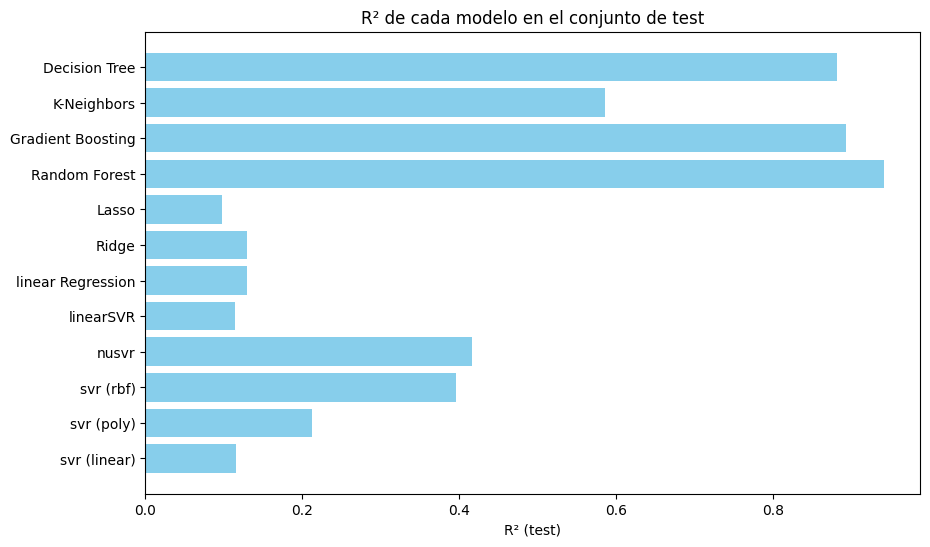

In [48]:
# Listas para almacenar nombres y valores de R²
nombres_modelos = []
r2_test_values = []

# Evaluar cada modelo
for nombre, modelo in regresores.items():
    modelo.fit(X_train, y_train_escalado)

    y_pred_test = modelo.predict(X_test)

    # Almacenar el nombre del modelo y su R² en el conjunto de test
    nombres_modelos.append(nombre)
    r2_test_values.append(r2_score(y_test_escalado, y_pred_test))

# Crear gráfico de barras con R² para cada modelo
plt.figure(figsize=(10, 6))
plt.barh(nombres_modelos, r2_test_values, color='skyblue')
plt.xlabel('R² (test)')
plt.title('R² de cada modelo en el conjunto de test')
plt.show()


ENTREGA 5: Responde:

 a) Responde mirando tu gráfico de R2:

 • El peor modelo y sus R2 de train y test: Lasso

• El mejor modelo y sus R2 de train y test: Random Forest

• Cuál es el que tiene más overfitting: Linear Regression

•Escoge uno de los modelos de máquinas de soporte vectorial y ajusta sus hiperparámetros a mano
hasta que mejores su R2 con respecto el valor inicial.

 •Si K-NN tiene overfitting, intenta mejorar la configuración del modelo de la misma forma.

In [50]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# Separar datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ajuste manual de hiperparámetros
svr_model = SVR(kernel='rbf', C=100, epsilon=0.01)  # Ajusta 'C' y 'epsilon'
svr_model.fit(X_train_scaled, y_train)

# Predicción y evaluación
y_pred_train = svr_model.predict(X_train_scaled)
y_pred_test = svr_model.predict(X_test_scaled)

r2_train_svr = r2_score(y_train, y_pred_train)
r2_test_svr = r2_score(y_test, y_pred_test)

print(f"R² en el conjunto de entrenamiento: {r2_train_svr:.4f}")
print(f"R² en el conjunto de test: {r2_test_svr:.4f}")


R² en el conjunto de entrenamiento: -0.0152
R² en el conjunto de test: -0.0203


ENTREGA 6: Muestra:

 a) Nombre del modelo SVR que has escogido.

 b) MSE y R2 original del SVR:

c) Código que realice los cambios a la configuración de los modelos SVR y K-NN, los entrene y
calcule sus nuevos scores.

 d) Gráfico de puntos de datos de test y predicciones de ambos.

 e) MSE y R2 mejorado de ambos:
